# Co-Optimization of Home Appliances

### Import Packages

In [1]:
## Import Packages
from cvxpy import *
import numpy as np
import pandas as pd
import xpress
import matplotlib.pyplot as plt
%matplotlib inline
# installed_solvers()

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /Users/taliaarauzo/miniconda3/envs/main/lib/python3.8/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


### Water Heater Optimization

Objective function and constraints for water heater, based on "Appliance Commitment for Household Load Scheduling" by Du and Lu.

In [19]:
# Generate data for control problem.
np.random.seed(1)

# Phyiscal parameters
R = 1.52 #thermal resistance [˚C/kW]
C = 863.4 #thermal capacitance [kWh/˚C]
Q = 4 #heater capacity [kW]
price = np.array(pd.read_csv("prices/prices_tou.csv").price_winter_kwh) #TOU pricing [$/kWh]
M = 50 #heater mass [gal]

# Optimization parameters
dt = 0.25 #time step [h]
n = int(24/dt) #number of time steps
T_0 = 60 #initial heater temp [˚C]
T_min = 55 #min heater temp [˚C]
T_max = 65 #max heater temp [˚C]
T_input = 25 #input heater temp [˚C]

# Water demand : https://learn.compactappliance.com/tankless-water-heater-sizing/
d = np.zeros(n) #heater water demand [gal]
shower_gpm = 1.6 #shower demand [gpm]
washer_gpm = 2.0 #washing machine demand [gpm]
d[37] = shower_gpm * dt * 60 #shower at 9 am
d[73] = washer_gpm * dt * 60/3 #washing machine from 6-6:45 pm
d[74] = washer_gpm * dt * 60/3 
d[75] = washer_gpm * dt * 60/3

# State space representation
beta = 10000 #ratio of increase for B
A = np.e**(-dt/(R*C))
B = beta*Q*R*(1-np.e**(-dt/(R*C)))

# Variables
T = Variable(n+1) #temperature
u = Variable(n, boolean = True) #on/off heater

# Cost function
alpha = 1 #ratio of penalty:cost
cost = sum(multiply(price*Q, u*dt))
for i in range(n+1):
    cost += alpha*0.5*(maximum(0, -T[i]+T_min)**2) #add in penalty function
# Constraints
constr = [T[0] == T_0]
for i in range(n):
    constr += [T[i+1] == A*(((M-d[i])*T[i])/M + (d[i]/M)*T_input) + B*u[i]]
    constr += [T[i+1] <= T_max]

### HVAC Optimization

Objective function and constraints for HVAC, based on "".

In [20]:
# Physical parameters
R=8.02  #[C/kW]
n_ac= 0.35 #[1/h]
A_floor = 100 # [m^2]
height = 3  #[m]
V_house=  A_floor*height #[m^3]
rho_air= 1.2 #[kg/m_3]
C_1 =  8.12   # [kWh/C]
C_2 = 1214.4/rho_air   #[J/(kg*C)]
P_heat=60*A_floor/1000 #[kW]
p=0.995
A_window=4

# # All irradiance in [W/m2]
# Location is Berkeley, CA --> (Lat, Lon) = (37.88, -122.25) 
df_raw = pd.read_csv('HVAC/62695_37.88_-122.25_2019_import.csv')
df_1 = df_raw
# making boolean series for a team name 
df_2 = df_1[df_1['Month'] == 3][df_1['Day'] == 15]
df_15=df_2[(df_2['Minute']==0) | (df_2['Minute']==15) | (df_2['Minute']==30) |(df_2['Minute']==45)]
def deg_to_rad(radians):
    return(radians * np.pi/180)

# Calculate irradiation on module
# Ref: https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-radiation-on-a-tilted-surface
GHI=df_15['GHI']
phi = 37.8715 # latitude of Berkeley
delta = 23.45 * np.sin(deg_to_rad(360/365 * (284 + 74))) # declination angle, March 15 is 74th day of year
alpha = 90 - phi + delta
beta = 90
S_module = np.array(GHI * (np.sin(deg_to_rad(alpha + beta)) / np.sin(deg_to_rad(alpha)))/1000) #[kW/m_2]

T_out=np.array(df_15['Temperature'])
dt=15/60 #[hr]
n=int(24/dt)  # time steps

dummy = n_ac*V_house*rho_air*C_2/3600000/C_1
A_d = np.exp((-1/C_1/R - dummy)*dt)
B_d = np.array([1/R+dummy*C_1, 1, A_window*(1-p)])*1/C_1*(1/(-1/(R*C_1)-dummy))*(np.exp((-1/(R*C_1)-dummy)*dt)-1)

T_min=20
T_max=24

# Define variables 
n=96
z=Variable(n, boolean=True)  #z_heating
T_in = Variable(n+1)
T_in_0 = 21  #[C]

# optimization starts
for i in range(n):
    constr += [ T_in[i+1] == A_d * T_in[i] + 
               np.matmul(B_d ,(np.array([T_out[i], P_heat*z[i], S_module[i]]).T))]
    constr += [T_in[i+1]>=T_min, T_in[i+1]<=T_max] 
constr += [T_in[0] == T_in_0]    
cost += sum(multiply(price*P_heat, z*dt))

<ipython-input-20-2c21a0d75159>:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_2 = df_1[df_1['Month'] == 3][df_1['Day'] == 15]


### Co-Optimization

In [21]:
# Solve optimization
problem = Problem(Minimize(cost), constr)
problem.solve(solver="XPRESS",verbose=True,bariterlimit=2,barindeflimit=1,bargapstop=1,bardualstop=1,barmemory=30)

 
Reading Problem CVX_xpress_qp
Problem Statistics
         194 (      0 spare) rows
         483 (      0 spare) structural columns
         578 (      0 spare) non-zero elements
          97 quadratic elements in objective
Global Statistics
         192 entities        0 sets        0 set members
FICO Xpress v8.11.3, Community, solve started 14:33:23, Apr 27, 2021
Heap usage: 517KB (peak 517KB, 1143KB system)
Minimizing MIQP CVX_xpress_qp with these control settings:
LPLOG = 1
MIPLOG = 2
OUTPUTLOG = 1
BARITERLIMIT = 2
BARINDEFLIMIT = 1
FEASTOL = 1.e-9
BARGAPSTOP = 1
BARDUALSTOP = 1
BARGAPTARGET = 1.e-30
Original problem has:
       676 rows          483 cols         1157 elements       192 globals
        97 qobjelem
Presolved problem has:
       197 rows          351 cols          546 elements       155 globals
        59 qobjelem
LP relaxation tightened
Presolve finished in 0 seconds
Heap usage: 649KB (peak 879KB, 1145KB system)

Coefficient range                    original       

16.20242766223769

In [34]:
# Cost of co-optimization
print("Cost of co-optimization: $", np.round(sum(multiply(price*Q, u*dt)).value + sum(multiply(price*P_heat, z*dt)).value, 4))

Cost of co-optimization: $ 8.9005


### Results

Optimal water heater temperature throughout the day, with shower and washing machine demands.

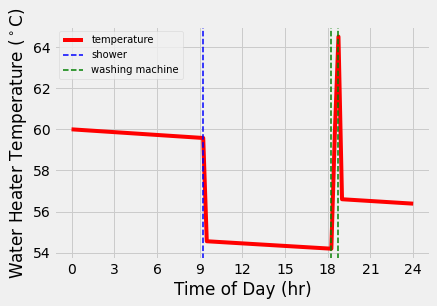

In [22]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.plot(T.value, 'red')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Water Heater Temperature ($^\circ$C)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);
position = [37,73,75]
colors = ['blue', 'green','green','green']
labels = []
for i,xc in enumerate(position):
    plt.axvline(x=xc, color=colors[i], linestyle='--', linewidth = 1.5)
plt.legend(['temperature','shower', 'washing machine'], prop={'size': 10});

Optimal water heater state (on/off) throughout the day, with shower and washing machine demands.

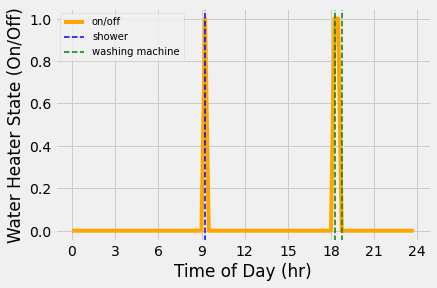

In [23]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.plot(u.value, 'orange')
plt.xlabel('Time of Day (hr)')
plt.ylabel('Water Heater State (On/Off)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);
position = [37,73,75]
colors = ['blue', 'green','green','green']
for i,xc in enumerate(position):
    plt.axvline(x=xc, color=colors[i], linestyle='--', linewidth = 1.5)
plt.legend(['on/off','shower', 'washing machine'], prop={'size': 10});

Optimal HVAC temperature throughout the day.

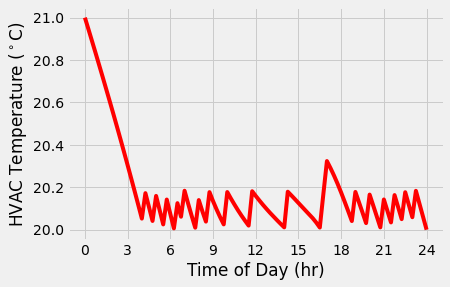

In [24]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.plot(T_in.value, 'red')
plt.xlabel('Time of Day (hr)')
plt.ylabel('HVAC Temperature ($^\circ$C)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);

Optimal HVAC state (on/off) throughout the day.

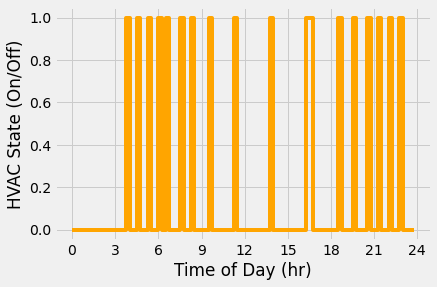

In [25]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()
plt.step(z.value, 'orange')
plt.xlabel('Time of Day (hr)')
plt.ylabel('HVAC State (On/Off)')
plt.xticks([0,12,24,36,48,60,72,84,96]);
ax.set_xticklabels([0,3,6,9,12,15,18,21,24]);